In [ ]:
import shap
import os
import contextlib
import tensorflow           as tf
import numpy                as np
import matplotlib.pyplot    as plt


import SHAP
import helper

In [2]:
class_labels = {
    0 : 'cat',
    1 : 'dog',
}

In [3]:
test_set = tf.data.Dataset.load('test_set')
test_set = test_set.shuffle(256)

2024-11-04 20:27:58.881992: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
model_extrcs = []
save_dir     = "models/diff_extrcs"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_extrcs.append(model)

In [6]:
extrc_names = ["Xception", "InceptionV3", "DenseNet121", "ResNet50V2"]

for i, model in enumerate(model_extrcs):
    model._name = extrc_names[i]
    print(model.name)

Xception
InceptionV3
DenseNet121
ResNet50V2


(64, 224, 224, 3)
(64,)
Normalized values:  (0.000126626, 1.0)


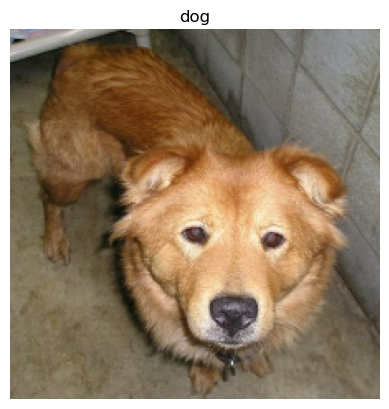

In [45]:
for img_batch, label_batch in test_set.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img_batch = np.array(img_batch)
    img = img_batch[0]
    print('Normalized values: ', (np.min(img), np.max(img)))
    plt.imshow(img)
    plt.title(class_labels[label_batch[0].numpy()])
    plt.axis('off')

In [46]:
for model in model_extrcs:
    pred = model.predict(tf.reshape(img, (-1,224,224,3)))[0][0]
    predicted_class = class_labels[1] if pred >= 0.5 else class_labels[0]
    confidence = pred if pred >= 0.5 else 1 - pred
    print(f"Predicted by {model.name} as {predicted_class} with Confidence of: {confidence * 100:.2f}%")

1/1 [==============================] - 0s 54ms/step
Predicted by Xception as dog with Confidence of: 99.78%
1/1 [==============================] - 0s 108ms/step
Predicted by InceptionV3 as dog with Confidence of: 99.06%
1/1 [==============================] - 0s 83ms/step
Predicted by DenseNet121 as dog with Confidence of: 99.84%
1/1 [==============================] - 0s 63ms/step
Predicted by ResNet50V2 as dog with Confidence of: 99.04%


In [47]:
instance         = (img * 255).astype(np.uint8)
instance_batched = np.expand_dims(instance, axis=0)

In [59]:
class_labels

{0: 'cat', 1: 'dog'}

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.76s/it]                                                                    


SHAP vizualization for model : Xception


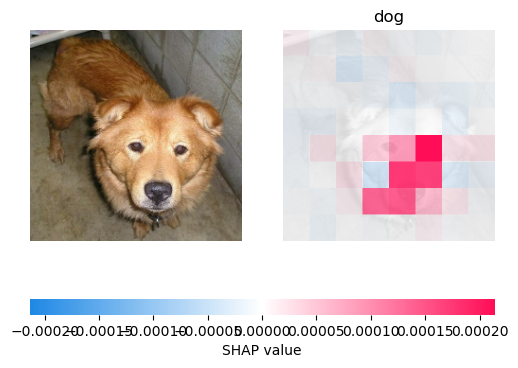

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:57, 57.40s/it]                                                                    

SHAP vizualization for model : InceptionV3


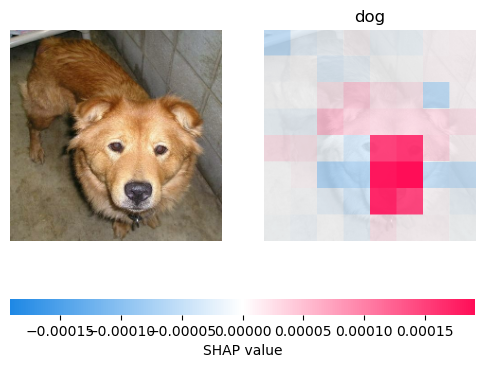

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:12, 72.12s/it]                                                                    


SHAP vizualization for model : DenseNet121


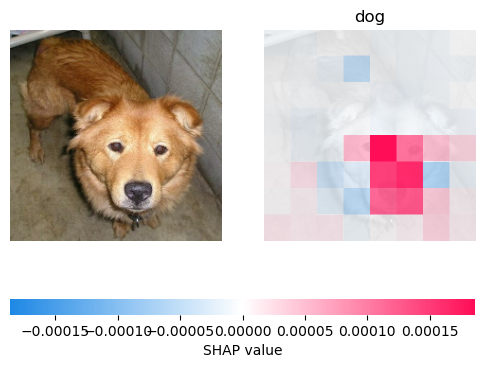

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.97s/it]                                                                    

SHAP vizualization for model : ResNet50V2


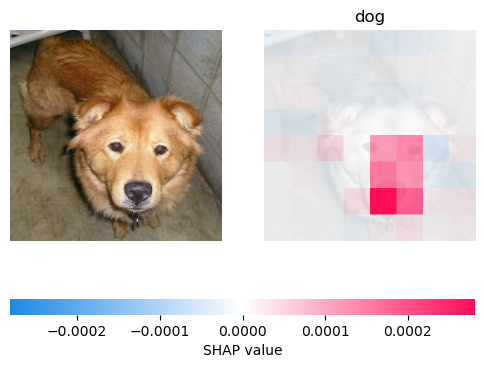

CPU times: user 6min 44s, sys: 1min 13s, total: 7min 58s
Wall time: 3min 55s


In [60]:
%%time
def predict_fn(images, model):
    images = images.astype(np.float32) / 255.0
    preds  = model.predict(images, verbose=0)

    if preds.shape[1] == 1:
        # Convert to probability of each class [P(class 0), P(class 1)]
        preds = np.hstack([1 - preds, preds])
        
    return preds

model_shap_values  = {}
masker             = shap.maskers.Image("inpaint_telea", (224,224,3))
output_names       = list(class_labels.values())

for model in model_extrcs:
    explainer = shap.Explainer(lambda x : predict_fn(x, model), 
                               masker, 
                               output_names = output_names)
    
    shap_values    = explainer(
        instance_batched, 
        batch_size = 500, 
        max_evals  = 1000, 
        outputs    = shap.Explanation.argsort.flip[:1]
    )

    model_shap_values[model.name] = shap_values.values[0]
    
    print(F"SHAP vizualization for model : {model.name}")
    shap.image_plot(shap_values, instance_batched)

In [5]:
samples = [helper.get_sample(i, test_set) for i in range(2)]

In [117]:
preds_extrcs   = [helper.get_predictions(model_extrcs, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_extrcs = [helper.filter_correct_predictions(prediction) for prediction in preds_extrcs]

Wrong Prediction at index 37 by ResNet50V2: Predicted dog, True cat
Wrong Prediction at index 8 by Xception: Predicted cat, True dog
Wrong Prediction at index 78 by Xception: Predicted cat, True dog
Wrong Prediction at index 88 by InceptionV3: Predicted cat, True dog


In [118]:
for sample_list in samples_extrcs:
    print(len(sample_list))

99
97


In [ ]:
%%time
save_directory = 'SHAP Expls/diff_extrcs'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        SHAP.generate_and_save_explanations(samples_extrcs, model_extrcs, save_directory)

In [120]:
model_opts     = []
save_directory = 'models/diff_opts/'

for model_file in os.listdir(save_directory):
    if model_file.endswith('.h5'):
        model_path = os.path.join(save_directory, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_opts.append(model)

In [121]:
preds_opts   = [helper.get_predictions(model_opts, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_opts = [helper.filter_correct_predictions(prediction) for prediction in preds_opts]

Wrong Prediction at index 7 by DenseNet-SGD: Predicted dog, True cat
Wrong Prediction at index 28 by DenseNet-SGD: Predicted dog, True cat
Wrong Prediction at index 83 by DenseNet-Nadam: Predicted dog, True cat
Wrong Prediction at index 8 by DenseNet-Adam: Predicted cat, True dog
Wrong Prediction at index 88 by DenseNet-Adam: Predicted cat, True dog


In [ ]:
%%time
save_directory = 'SHAP Expls/diff_opts'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        SHAP.generate_and_save_explanations(samples_opts, model_opts, save_directory)

In [6]:
# Models of Different seeds
model_seeds    = []

save_directory = "models/diff_seeds/"

for model_file in os.listdir(save_directory):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_directory, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

for i, model in enumerate(model_seeds):
    model._name = f'Dense{i+1}'
    print(model.name)

Dense1
Dense2
Dense3
Dense4
Dense5
Dense6
Dense7
Dense8
Dense9
Dense10


In [7]:
preds_seeds   = [helper.get_predictions(model_seeds, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_seeds = [helper.filter_correct_predictions(prediction) for prediction in preds_seeds]

Wrong Prediction at index 32 by Dense9: Predicted dog, True cat
Wrong Prediction at index 13 by Dense2: Predicted cat, True dog
Wrong Prediction at index 22 by Dense1: Predicted cat, True dog
Wrong Prediction at index 40 by Dense2: Predicted cat, True dog
Wrong Prediction at index 89 by Dense3: Predicted cat, True dog


In [12]:
import SHAP

In [ ]:
%%time
save_directory = 'SHAP Expls/diff_seeds'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        SHAP.generate_and_save_explanations(samples_seeds, model_seeds, save_directory)

In [22]:
import pickle
import shap
with open('SHAP Expls/diff_seeds/explain_cat_Dense1_shap.pkl', 'rb') as file:
    cat1_expl = pickle.load(file)

In [23]:
print(len(cat1_expl))

50


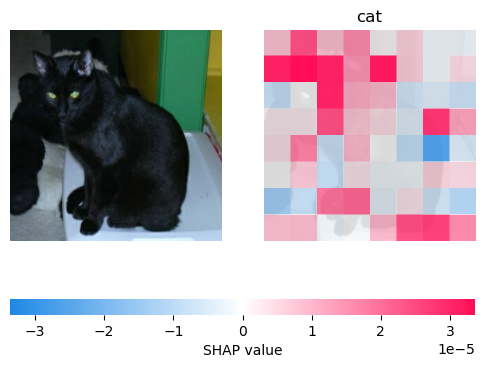

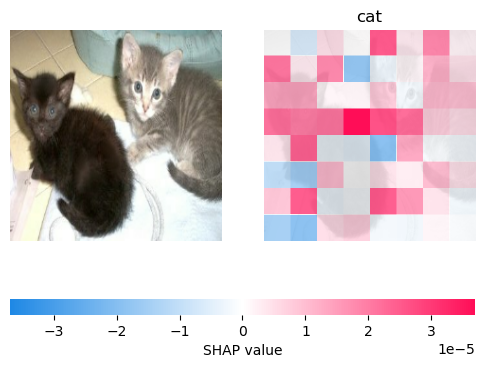

In [25]:
for expl in cat1_expl[:2]:
    shap.image_plot(expl)

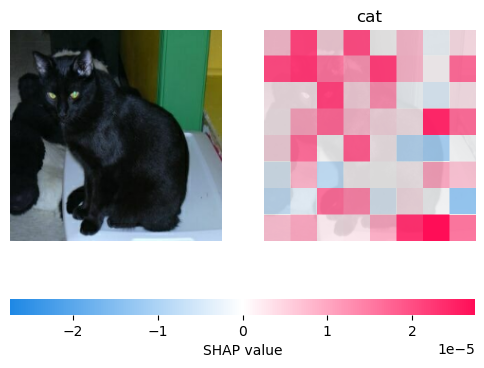

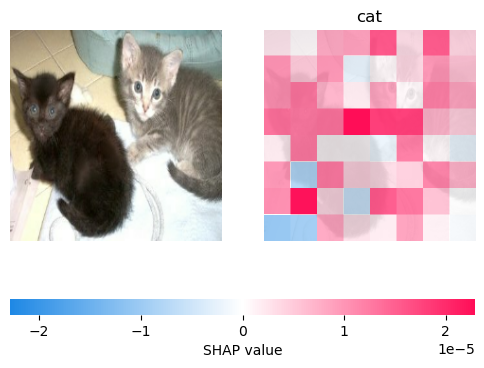

In [26]:
with open('SHAP Expls/diff_seeds/explain_cat_Dense2_shap.pkl', 'rb') as file:
    cat2_expl = pickle.load(file)

for expl in cat2_expl[:2]:
    shap.image_plot(expl)